# Pairs trading. Pairs selection. Cointegration (Part 2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
prices_train = pd.read_csv('vbr13_16.csv', index_col='Date')
prices_test = pd.read_csv('vbr16_19.csv', index_col='Date')

In [3]:
# calculate cumulative returns
cumret_train = np.log(prices_train).diff().cumsum()+1
cumret_train.dropna(how='all', inplace=True)
cumret_train.dropna(axis=1, inplace=True)
cumret_test = np.log(prices_test).diff().cumsum()+1
cumret_test.dropna(how='all', inplace=True)

In [4]:
# divide by first row so that all prices start at 1
cumret_train = cumret_train / cumret_train.iloc[0]
cumret_test = cumret_test / cumret_test.iloc[0]

# Functions to calculate different metrics

In [5]:
def parse_pair(pair):
    '''
    parse pair string S1-S2
    return tickers S1, S2
    '''
    dp = pair.find('-')
    s1 = pair[:dp]
    s2 = pair[dp+1:]
    
    return s1,s2

def cadf_pvalue(s1, s2, cumret):
    '''
    perform CADF cointegration tests
    since it is sensitive to the order of stocks in the pair, perform both tests (s1-2 and s2-s1)
    return the smallest p-value of two tests
    '''
    from statsmodels.tsa.stattools import coint
    
    p1 = coint(cumret[s1], cumret[s2])[1]
    p2 = coint(cumret[s2], cumret[s1])[1]
    
    return min(p1,p2)

def calculate_halflife(spread):
    '''
    calculate half-life of mean reversion of the spread
    '''
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    
    ylag = spread.shift()
    deltay = spread - ylag
    ylag.dropna(inplace=True)
    deltay.dropna(inplace=True)

    res = OLS(deltay, add_constant(ylag)).fit()
    halflife = -np.log(2)/res.params[0]
    
    return halflife

def calculate_metrics(pairs, cumret, pairs_df):
    '''
    calculate metrics for pairs using data in cumret
    return dataframe of results
    '''
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    from statsmodels.tsa.stattools import coint
    
    cols = ['Distance', 'CADF p-value', 'ADF p-value', 'Spread SD', 'Pearson r',
        'Num zero-crossings', 'Hurst Exponent', 'Half-life of mean reversion', '% days within historical 2-SD band']
    results = pd.DataFrame(index=pairs, columns=cols)
    
    for pair in pairs:
        s1,s2 = parse_pair(pair)
        hedge_ratio = pairs_df.loc[pair]['Hedge ratio']
        spread = cumret[s1] - hedge_ratio*cumret[s2]
        results.loc[pair]['CADF p-value'] = coint(cumret[s1], cumret[s2])[1]
        results.loc[pair]['ADF p-value'] = adfuller(spread)[1]
        hist_mu = pairs_df.loc[pair]['Spread mean'] # historical mean
        hist_sd = pairs_df.loc[pair]['Spread SD'] # historical standard deviation
        results.loc[pair]['Spread SD'] = hist_sd
        results.loc[pair]['Pearson r'] = np.corrcoef(cumret[s1], cumret[s2])[0][1]
        # subtract the mean to calculate distances and num_crossings
        spread_nm = spread - hist_mu
        results.loc[pair]['Distance'] = np.sqrt(np.sum((spread_nm)**2))
        results.loc[pair]['Num zero-crossings'] = ((spread_nm[1:].values * spread_nm[:-1].values) < 0).sum()
        results.loc[pair]['Hurst Exponent'] = compute_Hc(spread)[0]
        results.loc[pair]['Half-life of mean reversion'] = calculate_halflife(spread)
        results.loc[pair]['% days within historical 2-SD band'] = (abs(spread-hist_mu) < 2*hist_sd).sum() / len(spread) * 100
        
    return results

def plot_pairs(pairs, cumret_train, cumret_test):
    '''
    plot cumulative returns of the spread for each pair in pairs
    '''
    
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    
    for pair in pairs:
        s1,s2 = parse_pair(pair)
        res = OLS(cumret_train[s1], add_constant(cumret_train[s2])).fit()
        spread_train = cumret_train[s1] - res.params[s2]*cumret_train[s2]
        spread_test = cumret_test[s1] - res.params[s2]*cumret_test[s2]
        spread_mean = spread_train.mean() # historical mean
        spread_std = spread_train.std() # historical standard deviation

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,4))
        fig.suptitle(f'Spread of {pair} pair', fontsize=16)
        ax1.plot(spread_train, label='spread')
        ax1.set_title('Formation period')
        ax1.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax1.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax1.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax1.legend()
        ax2.plot(spread_test, label='spread')
        ax2.set_title('Trading period')
        ax2.axhline(y=spread_mean, color='g', linestyle='dotted', label='mean')
        ax2.axhline(y=spread_mean+2*spread_std, color='r', linestyle='dotted', label='2-SD band')
        ax2.axhline(y=spread_mean-2*spread_std, color='r', linestyle='dotted')
        ax2.legend()
        
def select_pairs(train):
    '''
    select pairs using data from train dataframe
    return dataframe of selected pairs
    '''
    tested = []

    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools.tools import add_constant
    from hurst import compute_Hc
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.tsa.stattools import coint

    cols = ['Distance', 'Num zero-crossings', 'Pearson r', 'Spread mean', 
            'Spread SD', 'Hurst Exponent', 'Half-life of mean reversion', 'Hedge ratio']
    pairs = pd.DataFrame(columns=cols)

    for s1 in train.columns:
        for s2 in train.columns:
            if s1!=s2 and (f'{s1}-{s2}' not in tested):
                tested.append(f'{s1}-{s2}')
                cadf_p = coint(train[s1], train[s2])[1]
                if cadf_p<0.01 and (f'{s2}-{s1}' not in pairs.index): # stop if pair already added as s2-s1
                    res = OLS(train[s1], add_constant(train[s2])).fit()
                    hedge_ratio = res.params[s2]
                    if hedge_ratio > 0: # hedge ratio should be posititve
                        spread = train[s1] - hedge_ratio*train[s2]
                        hurst = compute_Hc(spread)[0]
                        if hurst<0.5:
                            halflife = calculate_halflife(spread)
                            if halflife>1 and halflife<30:
                                # subtract the mean to calculate distances and num_crossings
                                spread_nm = spread - spread.mean() 
                                num_crossings = (spread_nm.values[1:] * spread_nm.values[:-1] < 0).sum()
                                if num_crossings>len(train.index)/252*12: 
                                    distance = np.sqrt(np.sum(spread_nm**2))
                                    pearson_r = np.corrcoef(train[s1], train[s2])[0][1]
                                    pairs.loc[f'{s1}-{s2}'] = [distance, num_crossings, pearson_r, spread.mean(),
                                                               spread.std(), hurst, halflife, hedge_ratio]
                                
    return pairs

In [6]:
# prepare data
train_form = cumret_train.loc['2013-01-01':'2015-12-31'] # formation period (train data)
train_trade = cumret_train.loc['2016-01-01':] # trading period (train data)
test_form = cumret_test.loc['2016-07-01':'2019-06-31'] # formation period (test data)
test_trade = cumret_test.loc['2019-07-01':] # trading period (test data)

In [27]:
train_form

,IEX,NUAN,MOH,NVAX,SBNY,PWR,WSM,FANG,BRO,STLD,...,KRO,UBA,HLX,RES,APEI,FF,PKI,ALGT,OII,DRQ
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2013-01-04,1.001038,1.001776,1.042914,1.010636,1.019168,1.010517,1.015788,1.046692,1.014636,1.024316,...,1.006934,0.995956,1.046731,1.036611,1.009943,0.991777,1.036011,1.023599,1.022879,1.004963
2013-01-07,1.006211,1.004434,1.054143,1.036754,1.025926,1.020925,0.998255,1.082157,1.011652,1.052069,...,1.000000,1.001009,1.038307,1.050739,0.984360,0.983486,1.032983,1.032371,1.015370,1.002484
2013-01-08,1.000830,1.019803,1.029199,1.015913,1.012910,1.028750,1.008249,1.073896,1.009407,1.027742,...,0.991014,0.992911,1.011162,1.034362,0.987827,0.981820,1.031466,1.015272,1.003554,1.002354
2013-01-09,1.006855,1.005319,1.030382,1.031584,1.015908,1.041076,1.001960,1.067532,1.001511,1.042004,...,0.983968,0.992911,1.004382,1.044072,1.006292,0.989297,1.071357,1.018793,1.004618,1.007824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,1.525601,0.876357,1.904007,2.524580,1.752899,0.706282,1.307521,2.273185,1.236427,1.315144,...,-0.075802,1.129424,-0.366239,1.059457,0.388335,1.236518,1.534673,1.886552,0.690296,0.786715
2015-12-28,1.520832,0.871831,1.911317,2.500082,1.760816,0.703351,1.315145,2.235639,1.237667,1.305162,...,-0.115506,1.138117,-0.423871,1.020605,0.372559,1.224383,1.536547,1.888341,0.672527,0.771671
2015-12-29,1.527143,0.872335,1.911656,2.549688,1.769568,0.710662,1.325220,2.251038,1.247834,1.318995,...,-0.117269,1.154780,-0.402358,1.010854,0.385396,1.232964,1.551790,1.904811,0.666532,0.770517


In [9]:
pairs_train = select_pairs(train_form)

In [10]:
pairs_train

,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
IEX-GRA,1.632826,56.0,0.925808,-0.444461,0.059464,0.378031,17.773619,1.444374
IEX-ADS,1.007115,79.0,0.972442,0.290001,0.036677,0.357466,16.505057,0.743826
MOH-SCI,1.819716,52.0,0.976015,-0.334390,0.066270,0.304781,12.654336,1.373158
MOH-FHN,2.578471,54.0,0.951233,-1.000129,0.093902,0.356214,14.266102,2.089341
MOH-POLY,3.428606,66.0,0.912004,-1.791482,0.124862,0.338789,14.860935,2.704551
...,...,...,...,...,...,...,...,...
KRO-MUR,2.774052,41.0,0.926225,-0.311004,0.101025,0.440060,20.279975,0.972470
KRO-SWN,2.681712,66.0,0.931234,0.154396,0.097662,0.426719,21.526618,0.554539
KRO-HSC,2.518113,47.0,0.939630,-0.105359,0.091704,0.394814,18.663369,0.875248
UBA-IRDM,1.303215,66.0,0.769064,0.718248,0.047460,0.386655,17.538026,0.347603


In [19]:
pairs_train.index.rename('Pair', inplace=True)
pairs_train.to_csv('pairs13_16.csv')

In [28]:
pairs_train = pd.read_csv('pairs13_16.csv', index_col='Pair')

In [11]:
pairs_test = select_pairs(test_form)

In [22]:
pairs_test

,Distance,Num zero-crossings,Pearson r,Spread mean,Spread SD,Hurst Exponent,Half-life of mean reversion,Hedge ratio
IEX-WTRG,2.730618,66.0,0.884017,-0.506094,0.099642,0.484466,17.565892,1.956274
IEX-WRLD,1.694440,50.0,0.957005,0.497293,0.061831,0.370805,15.621250,0.559448
NUAN-CXW,1.858561,42.0,0.590243,0.870551,0.067820,0.395403,17.434368,0.248202
MOH-DECK,3.625462,48.0,0.940827,0.119716,0.132295,0.357488,22.901431,1.009714
PWR-NCLH,1.992233,61.0,0.777443,0.579093,0.072698,0.413033,20.680678,0.666258
...,...,...,...,...,...,...,...,...
KRO-VAC,4.720938,51.0,0.923001,-0.186133,0.172269,0.466469,21.838402,1.779684
ALGT-SBNY,2.059645,74.0,0.764231,0.104947,0.075158,0.346171,15.569417,0.833889
SAGE-WTRG,8.306789,64.0,0.806599,-2.148353,0.303119,0.473166,21.884967,4.294153
SAGE-THG,5.223223,54.0,0.928362,-1.102879,0.190598,0.392825,17.515307,2.592024


In [23]:
pairs_test.index.rename('Pair', inplace=True)
pairs_test.to_csv('pairs16_19.csv')

In [29]:
pairs_test = pd.read_csv('pairs16_19.csv', index_col='Pair')

In [30]:
# calculate metrics for selected pairs
metrics_train_form = calculate_metrics(pairs_train.index, train_form, pairs_train) # in formation period
metrics_train_trade = calculate_metrics(pairs_train.index, train_trade, pairs_train) # in trading period

In [34]:
# add hedge ratio to metrics just in case
metrics_train_form['Hedge ratio'] = pairs_train['Hedge ratio']
metrics_train_form

,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band,Hedge ratio
Pair,,,,,,,,,,
IEX-GRA,1.632826,0.006148,0.001196,0.059464,0.925808,56,0.378031,17.773619,94.437086,1.444374
IEX-ADS,1.007115,0.00658,0.001291,0.036677,0.972442,79,0.357466,16.505057,95.231788,0.743826
MOH-SCI,1.819716,0.002281,0.000395,0.06627,0.976015,52,0.304781,12.654336,97.086093,1.373158
MOH-FHN,2.578471,0.002251,0.00039,0.093902,0.951233,54,0.356214,14.266102,95.629139,2.089341
MOH-POLY,3.428606,0.005746,0.00111,0.124862,0.912004,66,0.338789,14.860935,94.569536,2.704551
...,...,...,...,...,...,...,...,...,...,...
KRO-MUR,2.774052,0.005237,0.000996,0.101025,0.926225,41,0.44006,20.279975,94.834437,0.972470
KRO-SWN,2.681712,0.008362,0.001681,0.097662,0.931234,66,0.426719,21.526618,91.655629,0.554539
KRO-HSC,2.518113,0.00698,0.001378,0.091704,0.93963,47,0.394814,18.663369,96.821192,0.875248


In [536]:
metrics_train_trade

,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band
IEX-GRA,1.935227,0.359635,0.060086,0.059464,0.730099,0,0.514145,7.809895,16.8
IEX-ADS,3.135864,0.811656,0.306524,0.036677,-0.267519,2,0.681971,22.376005,13.6
MOH-SCI,2.162531,0.489425,0.825767,0.06627,-0.543965,9,0.660559,118.172663,43.2
MOH-FHN,2.260458,0.437727,0.768904,0.093902,-0.288848,4,0.611364,38.203629,48.8
MOH-POLY,8.459545,0.238943,0.493494,0.124862,-0.544188,0,0.417665,16.563784,0.0
...,...,...,...,...,...,...,...,...,...
KRO-MUR,2.37438,0.707573,0.775642,0.101025,0.785922,8,0.652624,31.320717,56.8
KRO-SWN,2.227729,0.757197,0.591413,0.097662,0.455455,14,0.574705,14.429702,52.8
KRO-HSC,3.042136,0.778722,0.218835,0.091704,0.015252,4,0.621712,14.995556,41.6
UBA-IRDM,1.344478,0.304541,0.6229,0.04746,0.685502,1,0.51671,20.256596,37.6


In [52]:
# repeat the procedure for test data
metrics_test_form = calculate_metrics(pairs_test.index, test_form, pairs_test)
metrics_test_trade = calculate_metrics(pairs_test.index, test_trade, pairs_test)
metrics_test_form['Hedge ratio'] = pairs_test['Hedge ratio']

# Data preparation

In [54]:
data_train = metrics_train_form.copy()
data_train['Num zero-crossings trade'] = metrics_train_trade['Num zero-crossings']
data_train

,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band,Hedge ratio,Num zero-crossings trade
Pair,,,,,,,,,,,
IEX-GRA,1.632826,0.006148,0.001196,0.059464,0.925808,56,0.378031,17.773619,94.437086,1.444374,0
IEX-ADS,1.007115,0.00658,0.001291,0.036677,0.972442,79,0.357466,16.505057,95.231788,0.743826,2
MOH-SCI,1.819716,0.002281,0.000395,0.06627,0.976015,52,0.304781,12.654336,97.086093,1.373158,9
MOH-FHN,2.578471,0.002251,0.00039,0.093902,0.951233,54,0.356214,14.266102,95.629139,2.089341,4
MOH-POLY,3.428606,0.005746,0.00111,0.124862,0.912004,66,0.338789,14.860935,94.569536,2.704551,0
...,...,...,...,...,...,...,...,...,...,...,...
KRO-MUR,2.774052,0.005237,0.000996,0.101025,0.926225,41,0.44006,20.279975,94.834437,0.972470,8
KRO-SWN,2.681712,0.008362,0.001681,0.097662,0.931234,66,0.426719,21.526618,91.655629,0.554539,14
KRO-HSC,2.518113,0.00698,0.001378,0.091704,0.93963,47,0.394814,18.663369,96.821192,0.875248,4


In [55]:
data_test = metrics_test_form.copy()
data_test['Num zero-crossings trade'] = metrics_test_trade['Num zero-crossings']
data_test

,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band,Hedge ratio,Num zero-crossings trade
Pair,,,,,,,,,,,
IEX-WTRG,2.730618,0.000387,0.000056,0.099642,0.884017,66,0.484466,17.565892,94.946809,1.956274,0
IEX-WRLD,1.69444,0.002033,0.000348,0.061831,0.957005,50,0.370805,15.62125,94.946809,0.559448,1
NUAN-CXW,1.858561,0.007038,0.001392,0.06782,0.590243,42,0.395403,17.434368,95.611702,0.248202,2
MOH-DECK,3.625462,0.007351,0.001463,0.132295,0.940827,48,0.357488,22.901431,95.212766,1.009714,2
PWR-NCLH,1.992233,0.006779,0.001333,0.072698,0.777443,61,0.413033,20.680678,96.276596,0.666258,2
...,...,...,...,...,...,...,...,...,...,...,...
KRO-VAC,4.720938,0.003736,0.000671,0.172269,0.923001,51,0.466469,21.838402,94.547872,1.779684,3
ALGT-SBNY,2.059645,0.005129,0.000976,0.075158,0.764231,74,0.346171,15.569417,94.680851,0.833889,0
SAGE-WTRG,8.306789,0.005289,0.001005,0.303119,0.806599,64,0.473166,21.884967,93.484043,4.294153,0


# Data exploration

In [56]:
data_train.dtypes

Distance                               object
CADF p-value                           object
ADF p-value                            object
Spread SD                              object
Pearson r                              object
Num zero-crossings                     object
Hurst Exponent                         object
Half-life of mean reversion            object
% days within historical 2-SD band     object
Hedge ratio                           float64
Num zero-crossings trade               object
dtype: object

In [57]:
# convert data to numeric types
data_train = data_train.apply(pd.to_numeric, errors='raise')
data_test = data_test.apply(pd.to_numeric, errors='raise')

In [58]:
data_test

,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band,Hedge ratio,Num zero-crossings trade
Pair,,,,,,,,,,,
IEX-WTRG,2.730618,0.000387,0.000056,0.099642,0.884017,66,0.484466,17.565892,94.946809,1.956274,0
IEX-WRLD,1.694440,0.002033,0.000348,0.061831,0.957005,50,0.370805,15.621250,94.946809,0.559448,1
NUAN-CXW,1.858561,0.007038,0.001392,0.067820,0.590243,42,0.395403,17.434368,95.611702,0.248202,2
MOH-DECK,3.625462,0.007351,0.001463,0.132295,0.940827,48,0.357488,22.901431,95.212766,1.009714,2
PWR-NCLH,1.992233,0.006779,0.001333,0.072698,0.777443,61,0.413033,20.680678,96.276596,0.666258,2
...,...,...,...,...,...,...,...,...,...,...,...
KRO-VAC,4.720938,0.003736,0.000671,0.172269,0.923001,51,0.466469,21.838402,94.547872,1.779684,3
ALGT-SBNY,2.059645,0.005129,0.000976,0.075158,0.764231,74,0.346171,15.569417,94.680851,0.833889,0
SAGE-WTRG,8.306789,0.005289,0.001005,0.303119,0.806599,64,0.473166,21.884967,93.484043,4.294153,0


In [59]:
data_train.dtypes

Distance                              float64
CADF p-value                          float64
ADF p-value                           float64
Spread SD                             float64
Pearson r                             float64
Num zero-crossings                      int64
Hurst Exponent                        float64
Half-life of mean reversion           float64
% days within historical 2-SD band    float64
Hedge ratio                           float64
Num zero-crossings trade                int64
dtype: object

In [60]:
data_train.describe()

,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band,Hedge ratio,Num zero-crossings trade
count,3471.000000,3471.000000,3471.000000,3471.000000,3471.000000,3471.000000,3471.000000,3471.000000,3471.000000,3471.000000,3471.000000
mean,1.695596,0.005192,0.001015,0.061750,0.735614,57.149237,0.395685,17.770617,95.563887,0.566997,4.806972
std,0.665908,0.002807,0.000616,0.024251,0.203136,12.331664,0.043139,3.389076,1.173536,0.539543,4.942630
min,0.585074,0.000013,0.000001,0.021307,0.014264,36.000000,0.265594,7.463036,90.596026,0.009092,0.000000
25%,1.263990,0.002779,0.000490,0.046032,0.595544,48.000000,0.365337,15.491395,94.834437,0.216277,0.000000
50%,1.617830,0.005278,0.001002,0.058918,0.807075,56.000000,0.388086,17.221904,95.629139,0.402972,4.000000
75%,1.957428,0.007607,0.001517,0.071285,0.899883,65.000000,0.426725,19.768839,96.423841,0.733469,8.000000
max,10.646180,0.010000,0.008945,0.387711,0.985815,112.000000,0.499863,29.997732,99.470199,5.457224,31.000000


In [61]:
# remove pairs with too big or too small hedge ratio
data_train = data_train[(data_train['Hedge ratio']>0.2) & (data_train['Hedge ratio']<5)]
data_test = data_test[(data_test['Hedge ratio']>0.2) & (data_test['Hedge ratio']<5)]

In [62]:
data_train.corr()

,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band,Hedge ratio,Num zero-crossings trade
Distance,1.000000,0.087266,0.074969,1.000000,-0.017007,-0.183337,0.228407,0.223740,-0.050221,0.620099,0.072840
CADF p-value,0.087266,1.000000,0.941899,0.087266,-0.075240,-0.145160,0.087630,0.394362,-0.014933,0.003389,-0.044795
ADF p-value,0.074969,0.941899,1.000000,0.074969,-0.069227,-0.142285,0.092813,0.380246,-0.015351,0.000426,-0.051568
Spread SD,1.000000,0.087266,0.074969,1.000000,-0.017007,-0.183337,0.228407,0.223740,-0.050221,0.620099,0.072840
Pearson r,-0.017007,-0.075240,-0.069227,-0.017007,1.000000,0.233454,-0.238813,-0.215635,-0.047267,0.434959,0.004335
Num zero-crossings,-0.183337,-0.145160,-0.142285,-0.183337,0.233454,1.000000,-0.275104,-0.415192,-0.283962,0.102914,-0.057648
Hurst Exponent,0.228407,0.087630,0.092813,0.228407,-0.238813,-0.275104,1.000000,0.625232,-0.105246,-0.053195,0.001760
Half-life of mean reversion,0.223740,0.394362,0.380246,0.223740,-0.215635,-0.415192,0.625232,1.000000,0.032024,-0.056613,-0.008223
% days within historical 2-SD band,-0.050221,-0.014933,-0.015351,-0.050221,-0.047267,-0.283962,-0.105246,0.032024,1.000000,-0.062090,-0.065158
Hedge ratio,0.620099,0.003389,0.000426,0.620099,0.434959,0.102914,-0.053195,-0.056613,-0.062090,1.000000,0.042865


# Visualize data

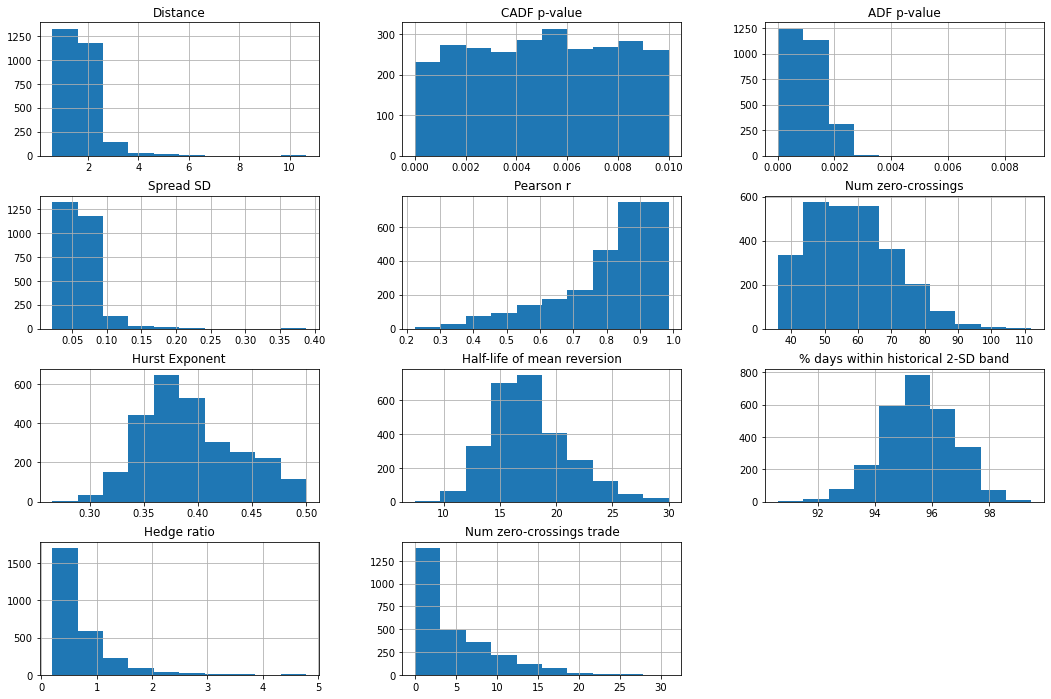

In [63]:
_ = data_train.hist(figsize=(18,12))

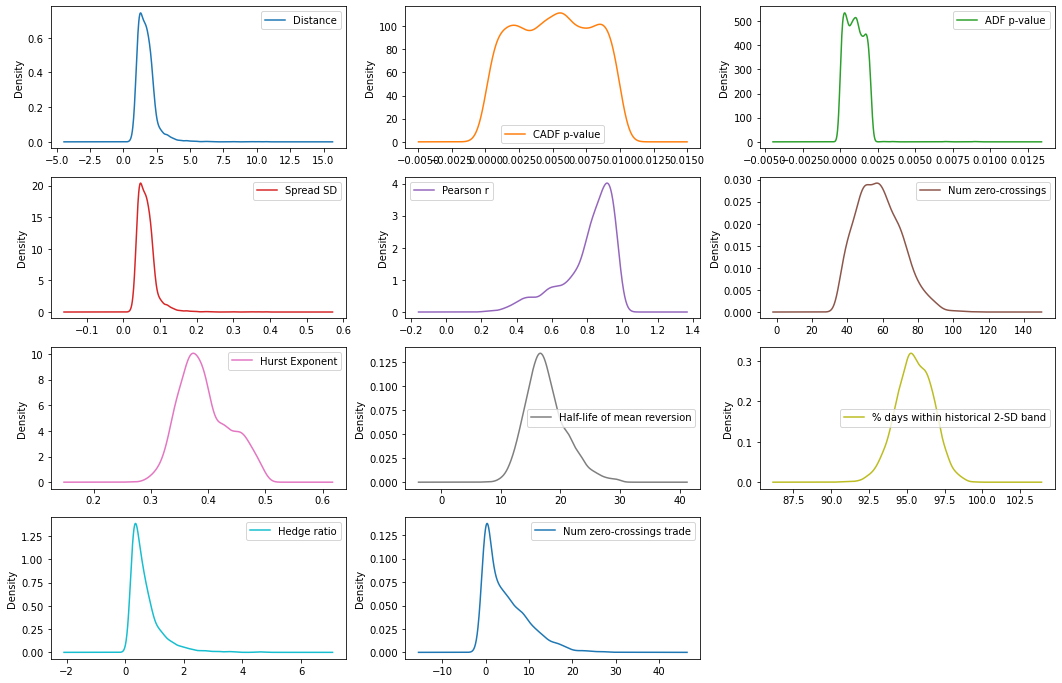

In [64]:
_ = data_train.plot(kind='density', subplots=True, layout=(4,3), sharex=False, figsize=(18,12))

## Classification

In [65]:
X_train = data_train.values[:,:10]
X_test = data_test.values[:,:10]
y_train = data_train.values[:,10]
y_test = data_test.values[:,10]

In [101]:
# what fraction of samples has more than 6 crossings?
len(y_train[y_train>6]) / len(y_train)

0.30207561156412155

In [103]:
from sklearn.preprocessing import Binarizer

# binarize dependent variable
binarizer = Binarizer(threshold=6).fit(y_train.reshape(-1,1))
y_train_bin = binarizer.transform(y_train.reshape(-1,1))
binarizer = Binarizer(threshold=6).fit(y_test.reshape(-1,1))
y_test_bin = binarizer.transform(y_test.reshape(-1,1))

In [104]:
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [105]:
def top10_accuracy(estimator, X, y):
    '''
    compute accuracy of top 10 predictions:
    select top 10 samples with the highest probability of belonging to class 1
    return the fraction of samples actually belonging to class1
    '''
    pred_prob = estimator.predict_proba(X)
    top10_ind = np.argsort(pred_prob[:,1])[-10:]
    score = sum(y[top10_ind] == np.ones(10))/10
    
    return score

In [106]:
def test_models_class(models, X=X_train, y=y_train_bin.flatten(), n_folds=10, scoring=top10_accuracy, seed=45):
    '''
    cross-validate each model in models using n_folds and scoring
    '''
    
    results = []
    names = []
    for name,model in models:
        kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print(f'{name}: {cv_results.mean()} ({cv_results.std()})')
        
    return results, names

In [107]:
models = []
models.append(('LR', LogisticRegression(max_iter=300, class_weight='balanced')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(class_weight='balanced')))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(class_weight='balanced', probability=True)))

In [108]:
results,names = test_models_class(models, y=y_train_bin.flatten())

LR: 0.4 (0.10954451150103323)
LDA: 0.43 (0.10049875621120889)
KNN: 0.35 (0.13601470508735444)
CART: 0.42000000000000004 (0.2181742422927143)
NB: 0.35 (0.15)
SVM: 0.26 (0.10198039027185571)


In [84]:
pipelines = []
for name,model in models:
    pipelines.append((f'scaled{name}', Pipeline([('scaler', PowerTransformer(method='box-cox')),
                                                 (name,model)])))
    
results,names = test_models_class(pipelines, y=y_train_bin.flatten())

scaledLR: 0.38 (0.10770329614269007)
scaledLDA: 0.39 (0.12206555615733701)
scaledKNN: 0.39 (0.1445683229480096)
scaledCART: 0.35 (0.16881943016134132)
scaledNB: 0.35 (0.0806225774829855)
scaledSVM: 0.42000000000000004 (0.116619037896906)


In [94]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

pipelines = []
for name,model in models:
    pipelines.append((f'scaled{name}_4ft', Pipeline([('scaler', PowerTransformer(method='box-cox')),
                                                 ('KBest', SelectKBest(score_func=f_classif, k=4)),
                                                 (name,model)])))
    
results,names = test_models_class(pipelines, y=y_train_bin.flatten())

scaledLR_4ft: 0.4 (0.07745966692414834)
scaledLDA_4ft: 0.39 (0.07)
scaledKNN_4ft: 0.43 (0.1345362404707371)
scaledCART_4ft: 0.4 (0.15491933384829668)
scaledNB_4ft: 0.36 (0.1624807680927192)
scaledSVM_4ft: 0.4699999999999999 (0.1552417469626002)


In [95]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

ensembles = []
ensembles.append(('ADA', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(class_weight='balanced')))
ensembles.append(('ET', ExtraTreesClassifier(class_weight='balanced')))

results,names = test_models_class(ensembles, y=y_train_bin.flatten())

ADA: 0.26999999999999996 (0.09)
GBM: 0.39 (0.15132745950421556)
RF: 0.41000000000000003 (0.10440306508910549)
ET: 0.5 (0.10954451150103321)


In [99]:
from sklearn.model_selection import GridSearchCV

n_estimators=[10,50,100,150]
max_depth = [5,7,10,15]
max_leaf_nodes = [50,100,150]
min_samples_leaf = [1,3,5,7,10,15]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, 
                  max_leaf_nodes=max_leaf_nodes, min_samples_leaf=min_samples_leaf)
model = ExtraTreesClassifier(class_weight='balanced')
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=45)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=top10_accuracy, cv=kfold)
grid_result = grid.fit(X_train, y_train_bin.flatten())

In [100]:
print(grid_result.best_score_)
print(grid_result.best_params_)

0.5499999999999999
{'max_depth': 10, 'max_leaf_nodes': 50, 'min_samples_leaf': 15, 'n_estimators': 10}


In [112]:
from sklearn.linear_model import LogisticRegressionCV

models = [('scaledLR_4ft_cv', Pipeline([('scaler', PowerTransformer(method='box-cox')), 
                            ('KBest', SelectKBest(score_func=f_classif, k=4)), 
                            ('LR', LogisticRegressionCV(max_iter=300, class_weight='balanced', 
                                                        scoring=top10_accuracy))]))]

results,names = test_models_class(models, y=y_train_bin.flatten())

scaledLR_4ft_cv: 0.39 (0.08306623862918076)


In [117]:
scaler = PowerTransformer(method='box-cox').fit(X_train)
scaledX = scaler.transform(X_train)
scaledX_4ft = SelectKBest(score_func=f_classif, k=4).fit_transform(X_train, y_train_bin.flatten())
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC(class_weight='balanced', probability=True)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=45)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=top10_accuracy, cv=kfold)
grid_result = grid.fit(scaledX_4ft, y_train_bin.flatten())

In [118]:
print(grid_result.best_score_)
print(grid_result.best_params_)

0.44000000000000006
{'C': 2, 'kernel': 'poly'}


In [119]:
scaler = PowerTransformer(method='box-cox').fit(X_train)
scaledX = scaler.transform(X_train)
scaledX_4ft = SelectKBest(score_func=f_classif, k=4).fit_transform(X_train, y_train_bin.flatten())
param_grid = dict(n_neighbors=np.arange(1,22,2))
model = KNeighborsClassifier()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=45)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=top10_accuracy, cv=kfold)
grid_result = grid.fit(scaledX_4ft, y_train_bin.flatten())

In [120]:
print(grid_result.best_score_)
print(grid_result.best_params_)

0.45
{'n_neighbors': 17}


In [121]:
# train ET using parameters obtained in grid search
model = ExtraTreesClassifier(class_weight='balanced', max_depth=10, max_leaf_nodes=50, 
                             min_samples_leaf=15, n_estimators=10)
model.fit(X_train, y_train_bin.flatten())

ExtraTreesClassifier(class_weight='balanced', max_depth=10, max_leaf_nodes=50,
                     min_samples_leaf=15, n_estimators=10)

In [124]:
# accuracy on train data
top10_accuracy(model, X_train, y_train_bin.flatten())

0.7

In [125]:
# accuracy on test data
top10_accuracy(model, X_test, y_test_bin.flatten())

0.7

In [154]:
pred_prob = model.predict_proba(X_test) # predict probabilities
# select top 10 pairs with highest probability of belonging to class 1 (sort in descending order)
top10_ind = np.argsort(pred_prob[:,1])[-10:][::-1] 
data_test.iloc[top10_ind,:] # show data

,Distance,CADF p-value,ADF p-value,Spread SD,Pearson r,Num zero-crossings,Hurst Exponent,Half-life of mean reversion,% days within historical 2-SD band,Hedge ratio,Num zero-crossings trade
Pair,,,,,,,,,,,
TMP-CSGS,1.928351,0.006789,0.001320,0.070367,0.310124,61,0.475563,20.577646,95.611702,0.236949,14
TMP-LZB,1.870479,0.006723,0.001307,0.068255,0.386797,57,0.474419,19.557580,94.946809,0.280420,8
TMP-CSR,1.988123,0.006221,0.001195,0.072548,0.198186,61,0.485521,20.860433,95.079787,0.211266,8
TMP-OFC,1.943130,0.005837,0.001113,0.070906,0.286826,51,0.480888,19.946301,96.143617,0.221576,12
TMP-CAKE,1.890621,0.007259,0.001426,0.068990,0.362214,57,0.473890,19.890982,95.079787,0.247349,0
KBR-MLHR,2.589303,0.003373,0.000610,0.094485,0.794564,53,0.377411,16.715340,94.015957,1.244333,8
NX-TGI,2.109642,0.002248,0.000389,0.076982,0.771207,53,0.355143,14.490933,94.680851,0.403560,19
TMP-NFG,1.998374,0.007011,0.001370,0.072922,0.171303,47,0.476394,20.874291,95.611702,0.226538,0
TMP-CBRL,1.955145,0.006236,0.001198,0.071344,0.266243,73,0.491093,20.045646,96.675532,0.235769,10


In [155]:
top50_ind = np.argsort(pred_prob[:,1])[-50:][::-1]
top50_pairs = data_test.iloc[top50_ind,:].index

selected_pairs = []
selected_stocks = []
for pair in top50_pairs:
    s1,s2 = parse_pair(pair)
    if (s1 not in selected_stocks) and (s2 not in selected_stocks):
        selected_stocks.append(s1)
        selected_stocks.append(s2)
        selected_pairs.append(pair)
        
        if len(selected_pairs)==5:
            break

In [156]:
selected_pairs

['TMP-CSGS', 'KBR-MLHR', 'NX-TGI', 'AAL-MHK', 'AMCX-FF']

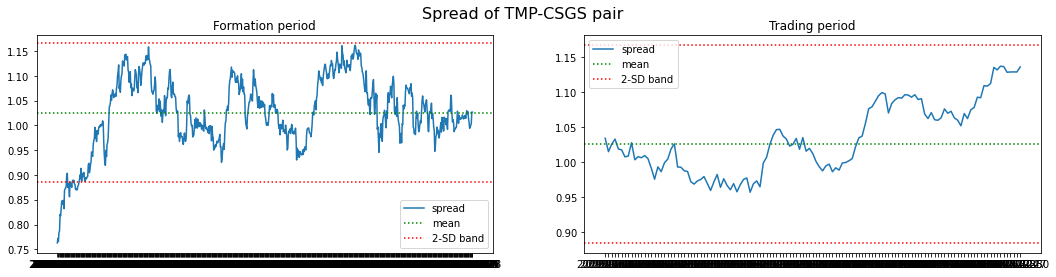

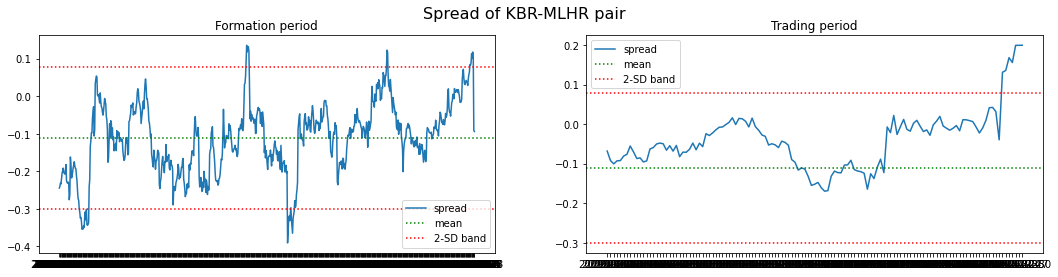

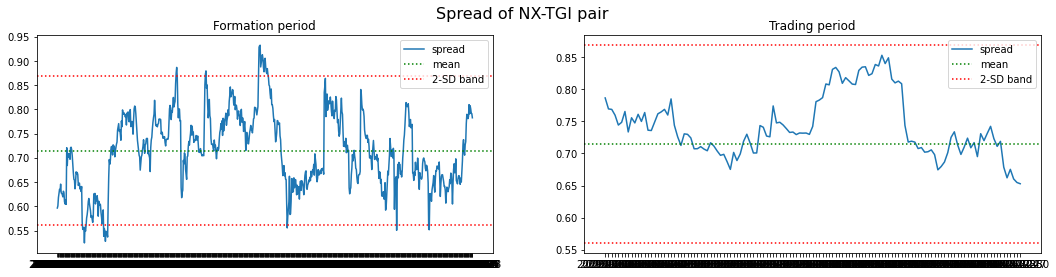

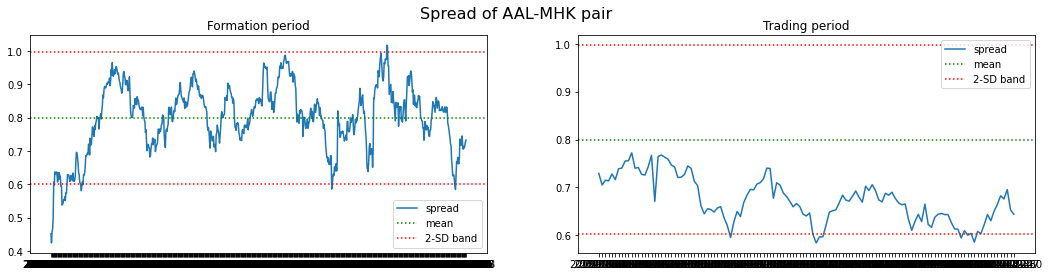

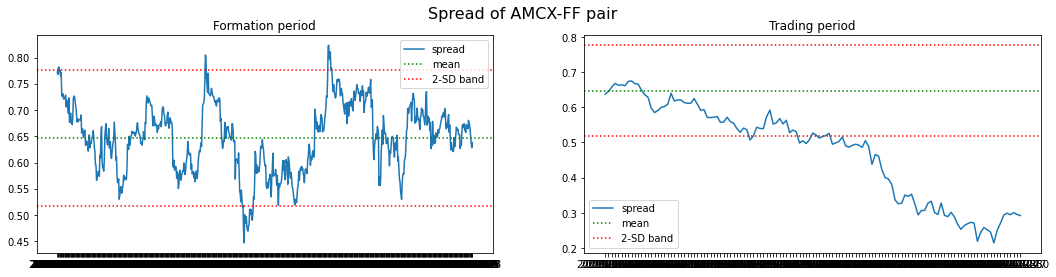

In [157]:
plot_pairs(selected_pairs, test_form, test_trade)